Found 4 image files
Model Memory Usage: 383.48 MB (RSS)
Model GPU Memory: 0.00 MB

Processing image 1/4: a4.jpg

0: 224x224 angry 0.89, sad 0.06, happy 0.03, fear 0.02, 9.0ms
Speed: 29.7ms preprocess, 9.0ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
Memory Usage:
  - Peak RAM: 446.69 MB
  - Peak GPU: 247.10 MB
  - Image Size: (1004, 1300, 3)


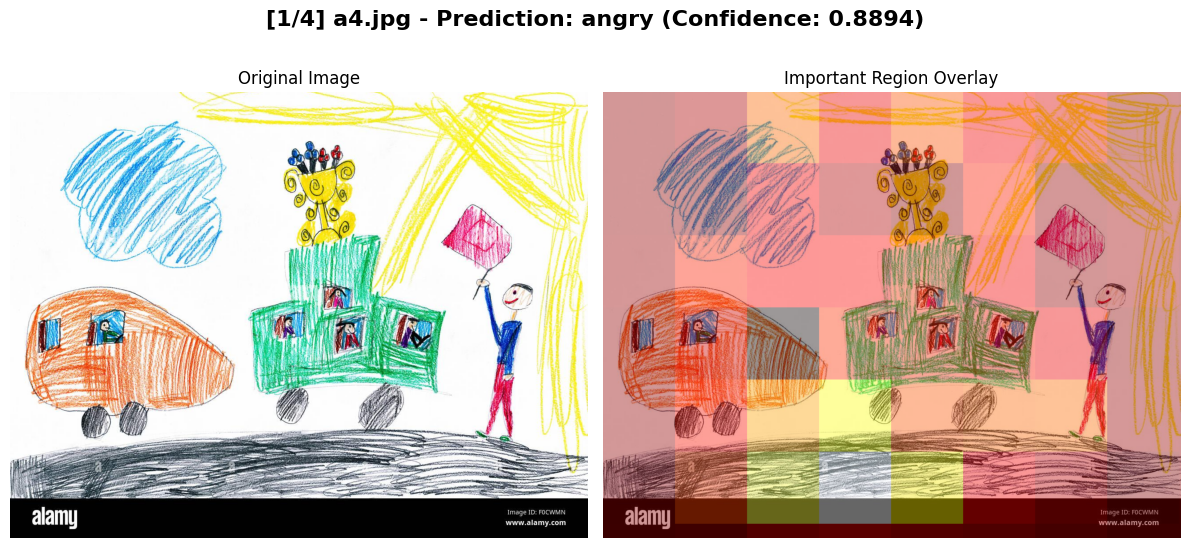

Predicted: angry (Confidence: 0.8894)

Processing image 2/4: f7.jpg
Memory Usage:
  - Peak RAM: 0.00 MB
  - Peak GPU: 0.00 MB
  - Image Size: (640, 640, 3)


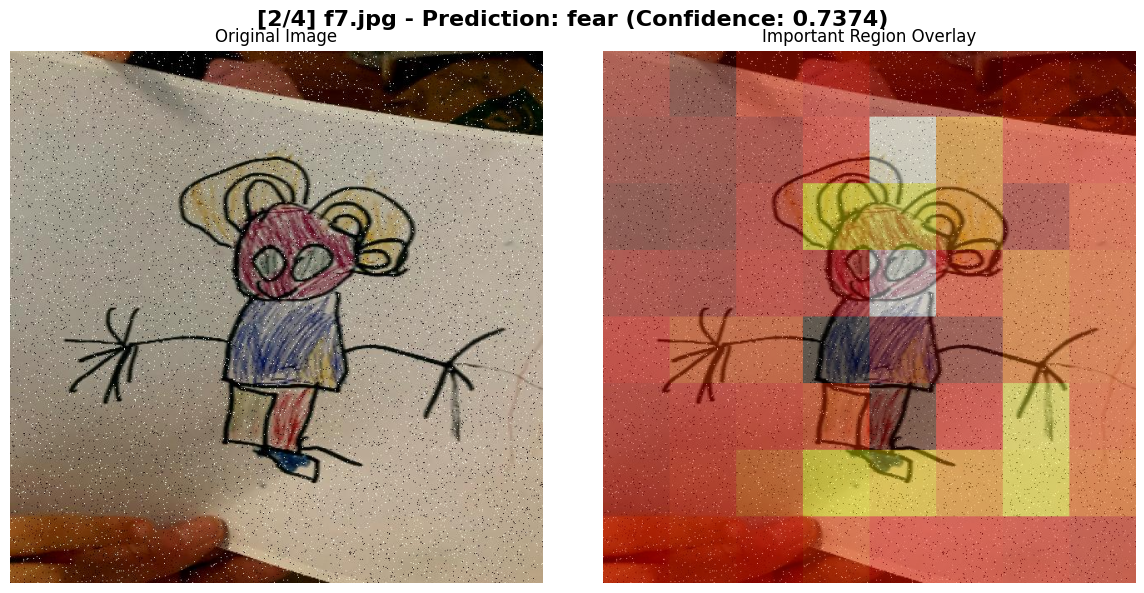

Predicted: fear (Confidence: 0.7374)

Processing image 3/4: h14.jpg
Memory Usage:
  - Peak RAM: 0.00 MB
  - Peak GPU: 0.00 MB
  - Image Size: (888, 1265, 3)


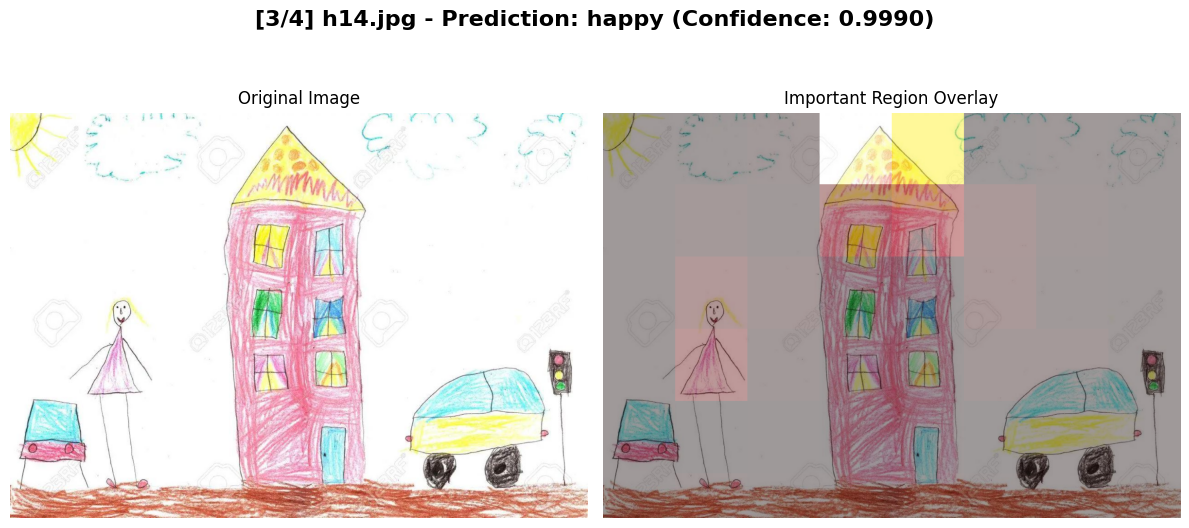

Predicted: happy (Confidence: 0.9990)

Processing image 4/4: new_s7.jpg
Memory Usage:
  - Peak RAM: 0.00 MB
  - Peak GPU: 0.00 MB
  - Image Size: (183, 275, 3)


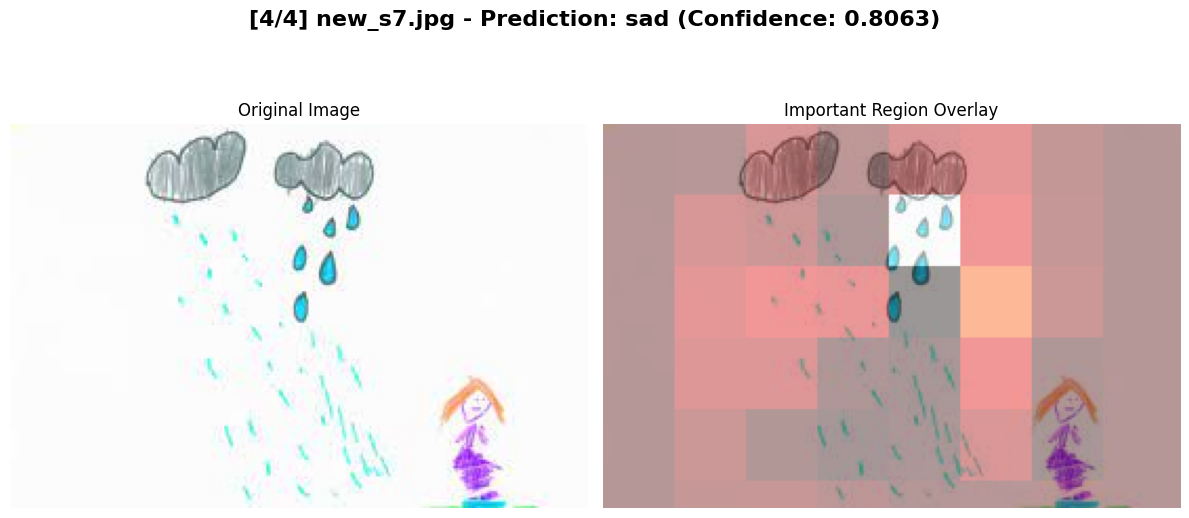

Predicted: sad (Confidence: 0.8063)

MEMORY USAGE SUMMARY
Model Base Memory: 383.48 MB
Per Image Processing:
  - Average RAM: 111.67 MB
  - Peak RAM: 446.69 MB
  - Min RAM: 0.00 MB
  - Average GPU: 61.78 MB
  - Peak GPU: 247.10 MB

Estimated Mobile Requirements:
  - Minimum RAM: 830.17 MB
  - Recommended RAM: 1245.25 MB (with safety margin)

All images processed successfully!


In [1]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import psutil
import gc
import torch

def get_memory_usage():
    """현재 메모리 사용량 반환 (MB 단위)"""
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    return {
        'rss': memory_info.rss / 1024 / 1024,  # 실제 물리 메모리 사용량
        'vms': memory_info.vms / 1024 / 1024,  # 가상 메모리 사용량
        'gpu': torch.cuda.memory_allocated() / 1024 / 1024 if torch.cuda.is_available() else 0
    }

def get_image_files(directory):
    """디렉터리에서 이미지 파일들을 찾아 정렬된 리스트로 반환"""
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff', '*.gif']
    image_files = []
    
    for extension in image_extensions:
        image_files.extend(glob.glob(os.path.join(directory, extension)))
        image_files.extend(glob.glob(os.path.join(directory, extension.upper())))
    
    return sorted(image_files)

def classify_single_image(model, image_path):
    """단일 이미지에 대한 분류 및 중요도 분석"""
    # 메모리 사용량 측정 시작
    mem_start = get_memory_usage()
    
    original_img = cv2.imread(image_path)
    original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    # 이미지 로드 후 메모리
    mem_after_load = get_memory_usage()
    
    # 예측 수행
    results = model(original_img_rgb)
    
    # 예측 후 메모리
    mem_after_prediction = get_memory_usage()
    
    # 중요도 맵 생성
    def get_feature_importance():
        h, w = original_img_rgb.shape[:2]
        importance_map = np.zeros((h, w))
        patch_size = max(h, w) // 8  # 이미지 크기에 맞게 패치 크기 조정
        
        for i in range(0, h, patch_size):
            for j in range(0, w, patch_size):
                masked_img = original_img_rgb.copy()
                masked_img[i:i+patch_size, j:j+patch_size] = masked_img.mean()
                
                masked_results = model(masked_img, verbose=False)
                masked_conf = masked_results[0].probs.top1conf.item()
                
                original_conf = results[0].probs.top1conf.item()
                importance = original_conf - masked_conf
                importance_map[i:i+patch_size, j:j+patch_size] = importance
        
        return importance_map
    
    # 결과 추출
    result = results[0]
    top_class_id = result.probs.top1
    top_class_name = model.names[top_class_id]
    top_confidence = result.probs.top1conf.item()
    
    importance_map = get_feature_importance()
    
    # 최종 메모리 사용량
    mem_final = get_memory_usage()
    
    # 메모리 정리
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # 메모리 정리 후
    mem_after_cleanup = get_memory_usage()
    
    return {
        'original_img': original_img_rgb,
        'importance_map': importance_map,
        'top_class_name': top_class_name,
        'top_confidence': top_confidence,
        'result': result,
        'memory_usage': {
            'start': mem_start,
            'after_load': mem_after_load,
            'after_prediction': mem_after_prediction,
            'final': mem_final,
            'after_cleanup': mem_after_cleanup,
            'peak_rss': mem_final['rss'] - mem_start['rss'],
            'peak_gpu': mem_final['gpu'] - mem_start['gpu']
        }
    }

def classify_directory_with_insights(model_path, image_directory):
    """디렉터리 내 모든 이미지를 분류하고 결과를 시각화"""
    # 모델 로드 전 메모리
    mem_before_model = get_memory_usage()
    
    model = YOLO(model_path)
    
    # 모델 로드 후 메모리
    mem_after_model = get_memory_usage()
    model_memory = mem_after_model['rss'] - mem_before_model['rss']
    
    image_files = get_image_files(image_directory)
    
    if not image_files:
        print(f"No image files found in {image_directory}")
        return
    
    print(f"Found {len(image_files)} image files")
    print(f"Model Memory Usage: {model_memory:.2f} MB (RSS)")
    if torch.cuda.is_available():
        print(f"Model GPU Memory: {mem_after_model['gpu']:.2f} MB")
    print("="*60)
    
    total_memory_stats = []
    
    for idx, image_path in enumerate(image_files):
        print(f"\nProcessing image {idx+1}/{len(image_files)}: {os.path.basename(image_path)}")
        
        try:
            analysis_result = classify_single_image(model, image_path)
            
            # 메모리 사용량 출력
            mem_stats = analysis_result['memory_usage']
            print(f"Memory Usage:")
            print(f"  - Peak RAM: {mem_stats['peak_rss']:.2f} MB")
            if torch.cuda.is_available():
                print(f"  - Peak GPU: {mem_stats['peak_gpu']:.2f} MB")
            print(f"  - Image Size: {analysis_result['original_img'].shape}")
            
            total_memory_stats.append(mem_stats)
            
            # 시각화 - 2개만 표시
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            
            # 1. Original Image
            axes[0].imshow(analysis_result['original_img'])
            axes[0].set_title('Original Image')
            axes[0].axis('off')
            
            # 2. Important Region Overlay
            axes[1].imshow(analysis_result['original_img'])
            axes[1].imshow(analysis_result['importance_map'], cmap='hot', alpha=0.4)
            axes[1].set_title('Important Region Overlay')
            axes[1].axis('off')
            
            fig.suptitle(f'[{idx+1}/{len(image_files)}] {os.path.basename(image_path)} - '
                        f'Prediction: {analysis_result["top_class_name"]} '
                        f'(Confidence: {analysis_result["top_confidence"]:.4f})', 
                        fontsize=16, fontweight='bold')
            
            plt.tight_layout()
            plt.show()
            
            # 간단한 결과 출력
            print(f"Predicted: {analysis_result['top_class_name']} (Confidence: {analysis_result['top_confidence']:.4f})")
                
        except Exception as e:
            print(f"Error processing {image_path}: {str(e)}")
            continue
    
    # 전체 통계 출력
    if total_memory_stats:
        print("\n" + "="*60)
        print("MEMORY USAGE SUMMARY")
        print("="*60)
        
        avg_ram = np.mean([stat['peak_rss'] for stat in total_memory_stats])
        max_ram = np.max([stat['peak_rss'] for stat in total_memory_stats])
        min_ram = np.min([stat['peak_rss'] for stat in total_memory_stats])
        
        print(f"Model Base Memory: {model_memory:.2f} MB")
        print(f"Per Image Processing:")
        print(f"  - Average RAM: {avg_ram:.2f} MB")
        print(f"  - Peak RAM: {max_ram:.2f} MB")
        print(f"  - Min RAM: {min_ram:.2f} MB")
        
        if torch.cuda.is_available():
            avg_gpu = np.mean([stat['peak_gpu'] for stat in total_memory_stats])
            max_gpu = np.max([stat['peak_gpu'] for stat in total_memory_stats])
            print(f"  - Average GPU: {avg_gpu:.2f} MB")
            print(f"  - Peak GPU: {max_gpu:.2f} MB")
        
        print(f"\nEstimated Mobile Requirements:")
        print(f"  - Minimum RAM: {model_memory + max_ram:.2f} MB")
        print(f"  - Recommended RAM: {(model_memory + max_ram) * 1.5:.2f} MB (with safety margin)")
    
    print("\nAll images processed successfully!")

# 사용법
if __name__ == "__main__":
    model_path = "/workspace/models/drawing_finetuned_yolov8x.pt"
    image_directory = "/workspace/testImg/testing"
    
    classify_directory_with_insights(model_path, image_directory)